In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
cwd = os.getcwd()

api_path = os.path.join(cwd, '..', 'tools', 'sampling_utils')
api_path_ml_est = os.path.join(cwd, '..', 'tools', 'ml_estimation')
api_path_data = os.path.join(api_path_ml_est, 'data', "sonar.all-data.csv")

sys.path.append(api_path)
sys.path.append(api_path_ml_est)

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import torch, torch.nn as nn
from functools import partial

from sir_ais_sampling import (sir_correlated_dynamics,
                              sir_independent_dynamics)

from distributions import (Target, 
                           Gaussian_mixture, 
                           IndependentNormal,
                           init_independent_normal)

from ebm_sampling import (MH_Transition, grad_energy, 
                          ais_dynamics, ais_vanilla_dynamics)

In [4]:
df = pd.read_csv(api_path_data, header = None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [5]:
inputs_df = df.drop(60, axis=1)
inputs_df['60'] = np.ones(inputs_df.shape[0])
targets_df = pd.get_dummies(df[60], dtype = np.int32)
inputs_df = torch.FloatTensor(inputs_df.to_numpy())
mine_y_df = torch.FloatTensor((targets_df['M'] * 2 - 1).to_numpy())


X_train, X_test, y_train, y_test = train_test_split(inputs_df, 
                                                    mine_y_df, 
                                                    test_size=0.30, 
                                                    random_state=42)
X_train_small = X_train[:, :-1]
X_test_small = X_test[:, :-1]

In [50]:
import scipy
from scipy.special import expit
from scipy.special import logsumexp

class BinaryLogisticLoss():
    def __init__(self, l2_coef):
        """
        Parameters
        ----------
        l2_coef - l2 regularization coefficient
        """
        self.l2_coef = l2_coef
        
    
    def func(self, w, X, y):
        """
        Get loss function value for data X, target y and coefficient w.

        Parameters
        ----------
        X : scipy.sparse.csr_matrix or numpy.ndarray
        y : 1d numpy.ndarray
        w : 1d numpy.ndarray

        Returns
        -------
        : float
        """
        exp_part = y[:, None] * (X @ w.T)
        batch_sigmoid = torch.logaddexp(torch.zeros_like(exp_part), -exp_part) #np.logaddexp(0., -exp_part) 
        return batch_sigmoid.sum(axis = 0) + self.l2_coef*(torch.norm(w[:, :-1], dim = 1)**2)
    
    def log_prob_args(self, w, X, y):
        return -self.func(w, X, y)
    
def calculate_losses(history, loss_fun, X_train, X_test, y_train, y_test):
    loss_train = []
    loss_test = []
    for _, w in enumerate(history):
        train_loss = loss_fun(w, X_train, y_train).item()
        test_loss = loss_fun(w, X_test, y_test).item()

        loss_train.append(train_loss)
        loss_test.append(test_loss)

        print('Iter: %d, Training loss: %f, Test loss %f' % (_,
                                                             loss_train[-1], 
                                                             loss_test[-1]))
    return loss_train, loss_test

In [51]:
from sklearn.linear_model import LogisticRegression
num_iter = np.arange(100) + 1
l2_coef = 0.5
target = BinaryLogisticLoss(l2_coef)
target.log_prob = partial(target.log_prob_args, 
                          X = X_train,
                          y = y_train)
for max_iter in num_iter:
    clf = LogisticRegression(random_state=42,
                             tol=1e-7,
                             max_iter = max_iter,
                             C = 1.).fit(X_train_small, y_train)
    w_clf = torch.FloatTensor(np.concatenate((clf.coef_, clf.intercept_.reshape(1, 1)), axis=1))
    train_loss_clf = target.func(w_clf, X_train, y_train).item()
    test_loss_clf = target.func(w_clf, X_test, y_test).item()
    print(f"max_iter = {max_iter}, train_loss = {train_loss_clf}, test_loss = {test_loss_clf}")

/usr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

max_iter = 1, train_loss = 99.28662872314453, test_loss = 42.49900817871094
max_iter = 2, train_loss = 94.23030090332031, test_loss = 40.01201629638672
max_iter = 3, train_loss = 79.78382873535156, test_loss = 35.72088623046875
max_iter = 4, train_loss = 77.30198669433594, test_loss = 35.9143180847168
max_iter = 5, train_loss = 76.53617858886719, test_loss = 36.64760208129883
max_iter = 6, train_loss = 76.18643951416016, test_loss = 37.23265075683594
max_iter = 7, train_loss = 75.81947326660156, test_loss = 37.725799560546875
max_iter = 8, train_loss = 75.5363998413086, test_loss = 38.059993743896484
max_iter = 9, train_loss = 75.3629379272461, test_loss = 38.14360046386719
max_iter = 10, train_loss = 75.29331970214844, test_loss = 37.927032470703125
max_iter = 11, train_loss = 75.13204193115234, test_loss = 37.54368591308594
max_iter = 12, train_loss = 75.131103515625, test_loss = 37.54471206665039
max_iter = 13, train_loss = 75.11470794677734, test_loss = 37.60944747924805
max_iter =

In [52]:
print(clf.score(X_train_small, y_train))
print(clf.score(X_test_small, y_test))

0.8551724137931035
0.8095238095238095


In [53]:
dim = X_train.shape[1]
zeros_start = torch.zeros((1, dim))
train_loss = target.func(zeros_start, X_train, y_train).item()
test_loss = target.func(zeros_start, X_test, y_test).item()
print(train_loss, test_loss)

100.50634002685547 43.66827392578125


# SIR 

In [64]:
device = 'cpu'
scale_proposal = 1
random_seed = 42
proposal = init_independent_normal(scale_proposal, dim, device)

n_steps = 10000
batch_size = 1
c = 0.1
N = 20
alpha = (1 - c/dim)**0.5
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
#start = proposal.sample([batch_size])
#start = torch.zeros((1, dim))
start = w_clf
history = sir_correlated_dynamics(start, 
                                  target,
                                  proposal, 
                                  n_steps, 
                                  N, 
                                  alpha)
loss_train, loss_test = calculate_losses(history, target.func, X_train, X_test, y_train, y_test)

Iter: 0, Training loss: 75.094955, Test loss 37.700752
Iter: 1, Training loss: 75.545776, Test loss 37.580746
Iter: 2, Training loss: 75.545776, Test loss 37.580746
Iter: 3, Training loss: 75.861404, Test loss 37.993317
Iter: 4, Training loss: 76.039352, Test loss 37.781975
Iter: 5, Training loss: 76.102188, Test loss 37.838821
Iter: 6, Training loss: 76.102348, Test loss 38.365021
Iter: 7, Training loss: 76.219376, Test loss 38.495014
Iter: 8, Training loss: 76.327370, Test loss 38.409966
Iter: 9, Training loss: 76.327370, Test loss 38.409966
Iter: 10, Training loss: 76.772285, Test loss 38.944267
Iter: 11, Training loss: 76.772285, Test loss 38.944267
Iter: 12, Training loss: 76.496658, Test loss 38.382988
Iter: 13, Training loss: 79.067848, Test loss 39.093723
Iter: 14, Training loss: 77.667419, Test loss 39.225380
Iter: 15, Training loss: 78.187485, Test loss 40.208534
Iter: 16, Training loss: 77.708405, Test loss 39.439526
Iter: 17, Training loss: 78.966774, Test loss 40.472313
It

Iter: 939, Training loss: 105.567474, Test loss 63.526649
Iter: 940, Training loss: 106.240082, Test loss 63.089439
Iter: 941, Training loss: 105.226227, Test loss 62.616463
Iter: 942, Training loss: 105.963333, Test loss 63.402306
Iter: 943, Training loss: 106.912186, Test loss 64.107933
Iter: 944, Training loss: 107.361450, Test loss 64.823158
Iter: 945, Training loss: 107.361450, Test loss 64.823158
Iter: 946, Training loss: 106.339600, Test loss 63.624386
Iter: 947, Training loss: 107.472778, Test loss 64.291924
Iter: 948, Training loss: 107.472778, Test loss 64.291924
Iter: 949, Training loss: 106.838303, Test loss 64.048386
Iter: 950, Training loss: 105.628296, Test loss 63.227375
Iter: 951, Training loss: 106.408356, Test loss 63.933403
Iter: 952, Training loss: 105.759872, Test loss 63.114372
Iter: 953, Training loss: 106.272057, Test loss 63.732132
Iter: 954, Training loss: 106.684402, Test loss 63.378960
Iter: 955, Training loss: 107.684570, Test loss 64.526344
Iter: 956, Tra

Iter: 1865, Training loss: 111.084076, Test loss 76.414322
Iter: 1866, Training loss: 110.927475, Test loss 76.271797
Iter: 1867, Training loss: 110.027908, Test loss 75.585266
Iter: 1868, Training loss: 111.862556, Test loss 76.634773
Iter: 1869, Training loss: 110.986412, Test loss 76.104980
Iter: 1870, Training loss: 110.752113, Test loss 75.827339
Iter: 1871, Training loss: 110.752113, Test loss 75.827339
Iter: 1872, Training loss: 111.982330, Test loss 77.422333
Iter: 1873, Training loss: 112.736481, Test loss 77.905670
Iter: 1874, Training loss: 112.581100, Test loss 77.588486
Iter: 1875, Training loss: 112.142975, Test loss 76.918198
Iter: 1876, Training loss: 112.482536, Test loss 77.150810
Iter: 1877, Training loss: 111.954956, Test loss 76.290527
Iter: 1878, Training loss: 112.100342, Test loss 76.206482
Iter: 1879, Training loss: 113.330200, Test loss 77.432663
Iter: 1880, Training loss: 112.820999, Test loss 76.926788
Iter: 1881, Training loss: 112.934052, Test loss 77.5039

Iter: 2768, Training loss: 119.173409, Test loss 78.999603
Iter: 2769, Training loss: 119.141533, Test loss 79.539299
Iter: 2770, Training loss: 119.171509, Test loss 79.434540
Iter: 2771, Training loss: 121.334244, Test loss 80.109268
Iter: 2772, Training loss: 119.862488, Test loss 79.485771
Iter: 2773, Training loss: 120.123398, Test loss 80.268539
Iter: 2774, Training loss: 120.951401, Test loss 80.618332
Iter: 2775, Training loss: 120.352654, Test loss 81.144058
Iter: 2776, Training loss: 121.202812, Test loss 82.573486
Iter: 2777, Training loss: 120.804581, Test loss 82.494926
Iter: 2778, Training loss: 121.403152, Test loss 83.550255
Iter: 2779, Training loss: 122.227722, Test loss 84.356567
Iter: 2780, Training loss: 123.429169, Test loss 84.681328
Iter: 2781, Training loss: 123.679626, Test loss 85.515854
Iter: 2782, Training loss: 126.547531, Test loss 87.799110
Iter: 2783, Training loss: 127.146179, Test loss 88.848320
Iter: 2784, Training loss: 127.470718, Test loss 88.6042

Iter: 3574, Training loss: 108.572189, Test loss 68.182938
Iter: 3575, Training loss: 108.744415, Test loss 68.503967
Iter: 3576, Training loss: 108.744415, Test loss 68.503967
Iter: 3577, Training loss: 109.102783, Test loss 68.854889
Iter: 3578, Training loss: 108.550674, Test loss 68.612823
Iter: 3579, Training loss: 108.525192, Test loss 68.613197
Iter: 3580, Training loss: 109.101601, Test loss 68.954277
Iter: 3581, Training loss: 110.057861, Test loss 69.737999
Iter: 3582, Training loss: 109.491974, Test loss 69.261093
Iter: 3583, Training loss: 109.426422, Test loss 69.360008
Iter: 3584, Training loss: 109.502045, Test loss 69.182632
Iter: 3585, Training loss: 109.834854, Test loss 69.318817
Iter: 3586, Training loss: 109.577530, Test loss 68.992142
Iter: 3587, Training loss: 111.780670, Test loss 69.757935
Iter: 3588, Training loss: 112.341698, Test loss 69.736862
Iter: 3589, Training loss: 110.616074, Test loss 68.993904
Iter: 3590, Training loss: 110.360718, Test loss 69.0167

Iter: 4472, Training loss: 101.831314, Test loss 61.069717
Iter: 4473, Training loss: 102.190178, Test loss 61.593639
Iter: 4474, Training loss: 102.254456, Test loss 62.078690
Iter: 4475, Training loss: 103.120071, Test loss 62.301746
Iter: 4476, Training loss: 103.506805, Test loss 62.955399
Iter: 4477, Training loss: 103.037354, Test loss 62.676208
Iter: 4478, Training loss: 102.878601, Test loss 63.410797
Iter: 4479, Training loss: 102.971481, Test loss 63.509666
Iter: 4480, Training loss: 103.482742, Test loss 63.985680
Iter: 4481, Training loss: 103.369713, Test loss 64.064667
Iter: 4482, Training loss: 102.183899, Test loss 63.037079
Iter: 4483, Training loss: 101.366669, Test loss 62.226765
Iter: 4484, Training loss: 101.158981, Test loss 61.971519
Iter: 4485, Training loss: 101.326309, Test loss 62.004112
Iter: 4486, Training loss: 101.045471, Test loss 61.994087
Iter: 4487, Training loss: 100.701492, Test loss 61.877098
Iter: 4488, Training loss: 100.406250, Test loss 61.9805

Iter: 5409, Training loss: 105.528946, Test loss 63.122314
Iter: 5410, Training loss: 104.608246, Test loss 62.261612
Iter: 5411, Training loss: 104.608246, Test loss 62.261612
Iter: 5412, Training loss: 105.245422, Test loss 62.856136
Iter: 5413, Training loss: 105.245895, Test loss 62.791050
Iter: 5414, Training loss: 105.201996, Test loss 63.500286
Iter: 5415, Training loss: 106.790146, Test loss 63.666794
Iter: 5416, Training loss: 106.967453, Test loss 64.640434
Iter: 5417, Training loss: 107.769897, Test loss 65.929626
Iter: 5418, Training loss: 106.866394, Test loss 64.970581
Iter: 5419, Training loss: 106.105316, Test loss 63.602310
Iter: 5420, Training loss: 106.478798, Test loss 64.132126
Iter: 5421, Training loss: 107.467545, Test loss 65.167786
Iter: 5422, Training loss: 107.081284, Test loss 65.202438
Iter: 5423, Training loss: 106.496147, Test loss 65.144424
Iter: 5424, Training loss: 105.621620, Test loss 63.732819
Iter: 5425, Training loss: 106.548264, Test loss 64.1911

Iter: 6332, Training loss: 102.188690, Test loss 57.859497
Iter: 6333, Training loss: 103.479462, Test loss 58.710178
Iter: 6334, Training loss: 102.981415, Test loss 58.674522
Iter: 6335, Training loss: 103.223015, Test loss 59.104538
Iter: 6336, Training loss: 104.041023, Test loss 59.299072
Iter: 6337, Training loss: 103.174698, Test loss 58.918762
Iter: 6338, Training loss: 102.905365, Test loss 58.982048
Iter: 6339, Training loss: 103.388260, Test loss 58.995087
Iter: 6340, Training loss: 103.080215, Test loss 59.090652
Iter: 6341, Training loss: 103.614731, Test loss 59.701324
Iter: 6342, Training loss: 104.365547, Test loss 60.512569
Iter: 6343, Training loss: 104.094620, Test loss 59.654236
Iter: 6344, Training loss: 105.460663, Test loss 60.648331
Iter: 6345, Training loss: 107.045975, Test loss 61.374672
Iter: 6346, Training loss: 106.698486, Test loss 60.843445
Iter: 6347, Training loss: 105.924843, Test loss 59.938198
Iter: 6348, Training loss: 106.927048, Test loss 60.4372

Iter: 7226, Training loss: 110.415977, Test loss 68.564354
Iter: 7227, Training loss: 109.018021, Test loss 67.701569
Iter: 7228, Training loss: 108.069305, Test loss 66.691765
Iter: 7229, Training loss: 107.437477, Test loss 66.373405
Iter: 7230, Training loss: 106.923401, Test loss 66.269470
Iter: 7231, Training loss: 110.178474, Test loss 67.825470
Iter: 7232, Training loss: 109.459641, Test loss 68.076630
Iter: 7233, Training loss: 107.369415, Test loss 66.482658
Iter: 7234, Training loss: 106.068092, Test loss 65.714279
Iter: 7235, Training loss: 107.379669, Test loss 66.444679
Iter: 7236, Training loss: 106.572990, Test loss 66.068832
Iter: 7237, Training loss: 107.387161, Test loss 66.870461
Iter: 7238, Training loss: 107.039383, Test loss 66.647545
Iter: 7239, Training loss: 107.989105, Test loss 67.136162
Iter: 7240, Training loss: 106.753342, Test loss 66.771790
Iter: 7241, Training loss: 106.753342, Test loss 66.771790
Iter: 7242, Training loss: 107.308571, Test loss 67.2301

Iter: 7829, Training loss: 104.176590, Test loss 65.616127
Iter: 7830, Training loss: 104.487778, Test loss 65.793686
Iter: 7831, Training loss: 104.192787, Test loss 65.520744
Iter: 7832, Training loss: 104.192787, Test loss 65.520744
Iter: 7833, Training loss: 104.019379, Test loss 65.265411
Iter: 7834, Training loss: 104.118820, Test loss 65.261047
Iter: 7835, Training loss: 104.160797, Test loss 65.428734
Iter: 7836, Training loss: 104.145569, Test loss 65.552200
Iter: 7837, Training loss: 104.226318, Test loss 65.749207
Iter: 7838, Training loss: 104.226318, Test loss 65.749207
Iter: 7839, Training loss: 103.354568, Test loss 65.159096
Iter: 7840, Training loss: 103.776382, Test loss 65.358093
Iter: 7841, Training loss: 103.492508, Test loss 65.149681
Iter: 7842, Training loss: 103.935959, Test loss 65.527039
Iter: 7843, Training loss: 104.892952, Test loss 66.328461
Iter: 7844, Training loss: 104.162170, Test loss 65.648964
Iter: 7845, Training loss: 105.240463, Test loss 66.6993

Iter: 8744, Training loss: 100.085220, Test loss 60.102661
Iter: 8745, Training loss: 100.028152, Test loss 59.604343
Iter: 8746, Training loss: 100.028152, Test loss 59.604343
Iter: 8747, Training loss: 100.236893, Test loss 59.344795
Iter: 8748, Training loss: 100.433334, Test loss 59.621078
Iter: 8749, Training loss: 100.876488, Test loss 59.797630
Iter: 8750, Training loss: 100.864014, Test loss 60.552170
Iter: 8751, Training loss: 101.605782, Test loss 60.810535
Iter: 8752, Training loss: 102.322731, Test loss 60.883362
Iter: 8753, Training loss: 103.671852, Test loss 60.482689
Iter: 8754, Training loss: 102.086769, Test loss 59.814941
Iter: 8755, Training loss: 101.084457, Test loss 59.519798
Iter: 8756, Training loss: 101.084457, Test loss 59.519798
Iter: 8757, Training loss: 101.169128, Test loss 59.602226
Iter: 8758, Training loss: 101.074036, Test loss 59.876690
Iter: 8759, Training loss: 101.067322, Test loss 59.352139
Iter: 8760, Training loss: 99.953926, Test loss 59.52330

Iter: 9661, Training loss: 113.334534, Test loss 75.382736
Iter: 9662, Training loss: 111.555023, Test loss 74.753204
Iter: 9663, Training loss: 112.310875, Test loss 75.287392
Iter: 9664, Training loss: 112.310875, Test loss 75.287392
Iter: 9665, Training loss: 112.528801, Test loss 75.148163
Iter: 9666, Training loss: 113.481812, Test loss 75.248169
Iter: 9667, Training loss: 113.614487, Test loss 75.569832
Iter: 9668, Training loss: 114.780518, Test loss 76.590286
Iter: 9669, Training loss: 114.780518, Test loss 76.590286
Iter: 9670, Training loss: 113.202385, Test loss 75.467194
Iter: 9671, Training loss: 113.387009, Test loss 75.254837
Iter: 9672, Training loss: 113.387009, Test loss 75.254837
Iter: 9673, Training loss: 113.688042, Test loss 75.590424
Iter: 9674, Training loss: 113.175919, Test loss 74.870949
Iter: 9675, Training loss: 112.953056, Test loss 74.532288
Iter: 9676, Training loss: 110.999390, Test loss 72.918343
Iter: 9677, Training loss: 110.999390, Test loss 72.9183

In [65]:
last_w = history[-1].numpy()
clf.coef_ = last_w[:, :-1]
clf.intercept_ = last_w[:, -1]
print(clf.score(X_train_small, y_train))
print(clf.score(X_test_small, y_test))

0.7862068965517242
0.6825396825396826


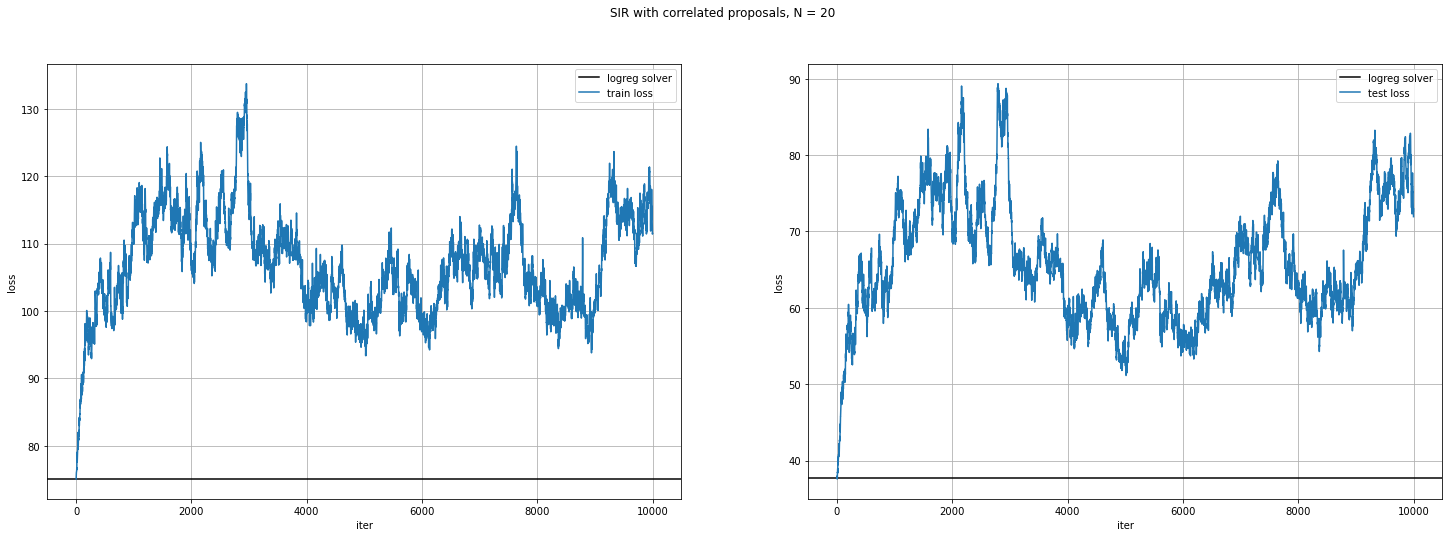

In [66]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25, 8))
name = f'SIR with сorrelated proposals, N = {N}'
fig.suptitle(name)

axs[0].axhline(train_loss_clf, label='logreg solver', color='black')
axs[0].set_xlabel('iter')
axs[0].set_ylabel('loss')
axs[0].plot(np.arange(len(loss_train)), loss_train, label = 'train loss')

axs[1].axhline(test_loss_clf, label='logreg solver', color='black')
axs[1].set_xlabel('iter')
axs[1].set_ylabel('loss')
axs[1].plot(np.arange(len(loss_test)), loss_test, label = 'test loss')


for ax in axs:
    ax.grid()
    ax.legend()

plt.show()

In [67]:
device = 'cpu'
scale_proposal = 1
random_seed = 42
dim = X_train.shape[1]
proposal = init_independent_normal(scale_proposal, dim, device)
l2_coef = 0.5
target = BinaryLogisticLoss(l2_coef)
target.log_prob = partial(target.log_prob_args, 
                          X = X_train,
                          y = y_train)
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
n_steps = 10000
N = 10
batch_size = 1
#start = proposal.sample([batch_size])
start = w_clf

In [68]:
history = sir_independent_dynamics(start, 
                                   target,
                                   proposal, 
                                   n_steps, 
                                   N)
loss_train, loss_test = calculate_losses(history, target.func, X_train, X_test, y_train, y_test)

Iter: 0, Training loss: 75.094955, Test loss 37.700752
Iter: 1, Training loss: 75.094955, Test loss 37.700752
Iter: 2, Training loss: 75.094955, Test loss 37.700752
Iter: 3, Training loss: 75.094955, Test loss 37.700752
Iter: 4, Training loss: 75.094955, Test loss 37.700752
Iter: 5, Training loss: 75.094955, Test loss 37.700752
Iter: 6, Training loss: 75.094955, Test loss 37.700752
Iter: 7, Training loss: 75.094955, Test loss 37.700752
Iter: 8, Training loss: 75.094955, Test loss 37.700752
Iter: 9, Training loss: 75.094955, Test loss 37.700752
Iter: 10, Training loss: 75.094955, Test loss 37.700752
Iter: 11, Training loss: 75.094955, Test loss 37.700752
Iter: 12, Training loss: 75.094955, Test loss 37.700752
Iter: 13, Training loss: 75.094955, Test loss 37.700752
Iter: 14, Training loss: 75.094955, Test loss 37.700752
Iter: 15, Training loss: 75.094955, Test loss 37.700752
Iter: 16, Training loss: 75.094955, Test loss 37.700752
Iter: 17, Training loss: 75.094955, Test loss 37.700752
It

Iter: 874, Training loss: 75.094955, Test loss 37.700752
Iter: 875, Training loss: 75.094955, Test loss 37.700752
Iter: 876, Training loss: 75.094955, Test loss 37.700752
Iter: 877, Training loss: 75.094955, Test loss 37.700752
Iter: 878, Training loss: 75.094955, Test loss 37.700752
Iter: 879, Training loss: 75.094955, Test loss 37.700752
Iter: 880, Training loss: 75.094955, Test loss 37.700752
Iter: 881, Training loss: 75.094955, Test loss 37.700752
Iter: 882, Training loss: 75.094955, Test loss 37.700752
Iter: 883, Training loss: 75.094955, Test loss 37.700752
Iter: 884, Training loss: 75.094955, Test loss 37.700752
Iter: 885, Training loss: 75.094955, Test loss 37.700752
Iter: 886, Training loss: 75.094955, Test loss 37.700752
Iter: 887, Training loss: 75.094955, Test loss 37.700752
Iter: 888, Training loss: 75.094955, Test loss 37.700752
Iter: 889, Training loss: 75.094955, Test loss 37.700752
Iter: 890, Training loss: 75.094955, Test loss 37.700752
Iter: 891, Training loss: 75.09

Iter: 1648, Training loss: 75.094955, Test loss 37.700752
Iter: 1649, Training loss: 75.094955, Test loss 37.700752
Iter: 1650, Training loss: 75.094955, Test loss 37.700752
Iter: 1651, Training loss: 75.094955, Test loss 37.700752
Iter: 1652, Training loss: 75.094955, Test loss 37.700752
Iter: 1653, Training loss: 75.094955, Test loss 37.700752
Iter: 1654, Training loss: 75.094955, Test loss 37.700752
Iter: 1655, Training loss: 75.094955, Test loss 37.700752
Iter: 1656, Training loss: 75.094955, Test loss 37.700752
Iter: 1657, Training loss: 75.094955, Test loss 37.700752
Iter: 1658, Training loss: 75.094955, Test loss 37.700752
Iter: 1659, Training loss: 75.094955, Test loss 37.700752
Iter: 1660, Training loss: 75.094955, Test loss 37.700752
Iter: 1661, Training loss: 75.094955, Test loss 37.700752
Iter: 1662, Training loss: 75.094955, Test loss 37.700752
Iter: 1663, Training loss: 75.094955, Test loss 37.700752
Iter: 1664, Training loss: 75.094955, Test loss 37.700752
Iter: 1665, Tr

Iter: 2621, Training loss: 75.094955, Test loss 37.700752
Iter: 2622, Training loss: 75.094955, Test loss 37.700752
Iter: 2623, Training loss: 75.094955, Test loss 37.700752
Iter: 2624, Training loss: 75.094955, Test loss 37.700752
Iter: 2625, Training loss: 75.094955, Test loss 37.700752
Iter: 2626, Training loss: 75.094955, Test loss 37.700752
Iter: 2627, Training loss: 75.094955, Test loss 37.700752
Iter: 2628, Training loss: 75.094955, Test loss 37.700752
Iter: 2629, Training loss: 75.094955, Test loss 37.700752
Iter: 2630, Training loss: 75.094955, Test loss 37.700752
Iter: 2631, Training loss: 75.094955, Test loss 37.700752
Iter: 2632, Training loss: 75.094955, Test loss 37.700752
Iter: 2633, Training loss: 75.094955, Test loss 37.700752
Iter: 2634, Training loss: 75.094955, Test loss 37.700752
Iter: 2635, Training loss: 75.094955, Test loss 37.700752
Iter: 2636, Training loss: 75.094955, Test loss 37.700752
Iter: 2637, Training loss: 75.094955, Test loss 37.700752
Iter: 2638, Tr

Iter: 3568, Training loss: 75.094955, Test loss 37.700752
Iter: 3569, Training loss: 75.094955, Test loss 37.700752
Iter: 3570, Training loss: 75.094955, Test loss 37.700752
Iter: 3571, Training loss: 75.094955, Test loss 37.700752
Iter: 3572, Training loss: 75.094955, Test loss 37.700752
Iter: 3573, Training loss: 75.094955, Test loss 37.700752
Iter: 3574, Training loss: 75.094955, Test loss 37.700752
Iter: 3575, Training loss: 75.094955, Test loss 37.700752
Iter: 3576, Training loss: 75.094955, Test loss 37.700752
Iter: 3577, Training loss: 75.094955, Test loss 37.700752
Iter: 3578, Training loss: 75.094955, Test loss 37.700752
Iter: 3579, Training loss: 75.094955, Test loss 37.700752
Iter: 3580, Training loss: 75.094955, Test loss 37.700752
Iter: 3581, Training loss: 75.094955, Test loss 37.700752
Iter: 3582, Training loss: 75.094955, Test loss 37.700752
Iter: 3583, Training loss: 75.094955, Test loss 37.700752
Iter: 3584, Training loss: 75.094955, Test loss 37.700752
Iter: 3585, Tr

Iter: 4449, Training loss: 75.094955, Test loss 37.700752
Iter: 4450, Training loss: 75.094955, Test loss 37.700752
Iter: 4451, Training loss: 75.094955, Test loss 37.700752
Iter: 4452, Training loss: 75.094955, Test loss 37.700752
Iter: 4453, Training loss: 75.094955, Test loss 37.700752
Iter: 4454, Training loss: 75.094955, Test loss 37.700752
Iter: 4455, Training loss: 75.094955, Test loss 37.700752
Iter: 4456, Training loss: 75.094955, Test loss 37.700752
Iter: 4457, Training loss: 75.094955, Test loss 37.700752
Iter: 4458, Training loss: 75.094955, Test loss 37.700752
Iter: 4459, Training loss: 75.094955, Test loss 37.700752
Iter: 4460, Training loss: 75.094955, Test loss 37.700752
Iter: 4461, Training loss: 75.094955, Test loss 37.700752
Iter: 4462, Training loss: 75.094955, Test loss 37.700752
Iter: 4463, Training loss: 75.094955, Test loss 37.700752
Iter: 4464, Training loss: 75.094955, Test loss 37.700752
Iter: 4465, Training loss: 75.094955, Test loss 37.700752
Iter: 4466, Tr

Iter: 5071, Training loss: 75.094955, Test loss 37.700752
Iter: 5072, Training loss: 75.094955, Test loss 37.700752
Iter: 5073, Training loss: 75.094955, Test loss 37.700752
Iter: 5074, Training loss: 75.094955, Test loss 37.700752
Iter: 5075, Training loss: 75.094955, Test loss 37.700752
Iter: 5076, Training loss: 75.094955, Test loss 37.700752
Iter: 5077, Training loss: 75.094955, Test loss 37.700752
Iter: 5078, Training loss: 75.094955, Test loss 37.700752
Iter: 5079, Training loss: 75.094955, Test loss 37.700752
Iter: 5080, Training loss: 75.094955, Test loss 37.700752
Iter: 5081, Training loss: 75.094955, Test loss 37.700752
Iter: 5082, Training loss: 75.094955, Test loss 37.700752
Iter: 5083, Training loss: 75.094955, Test loss 37.700752
Iter: 5084, Training loss: 75.094955, Test loss 37.700752
Iter: 5085, Training loss: 75.094955, Test loss 37.700752
Iter: 5086, Training loss: 75.094955, Test loss 37.700752
Iter: 5087, Training loss: 75.094955, Test loss 37.700752
Iter: 5088, Tr

Iter: 5735, Training loss: 75.094955, Test loss 37.700752
Iter: 5736, Training loss: 75.094955, Test loss 37.700752
Iter: 5737, Training loss: 75.094955, Test loss 37.700752
Iter: 5738, Training loss: 75.094955, Test loss 37.700752
Iter: 5739, Training loss: 75.094955, Test loss 37.700752
Iter: 5740, Training loss: 75.094955, Test loss 37.700752
Iter: 5741, Training loss: 75.094955, Test loss 37.700752
Iter: 5742, Training loss: 75.094955, Test loss 37.700752
Iter: 5743, Training loss: 75.094955, Test loss 37.700752
Iter: 5744, Training loss: 75.094955, Test loss 37.700752
Iter: 5745, Training loss: 75.094955, Test loss 37.700752
Iter: 5746, Training loss: 75.094955, Test loss 37.700752
Iter: 5747, Training loss: 75.094955, Test loss 37.700752
Iter: 5748, Training loss: 75.094955, Test loss 37.700752
Iter: 5749, Training loss: 75.094955, Test loss 37.700752
Iter: 5750, Training loss: 75.094955, Test loss 37.700752
Iter: 5751, Training loss: 75.094955, Test loss 37.700752
Iter: 5752, Tr

Iter: 6381, Training loss: 75.094955, Test loss 37.700752
Iter: 6382, Training loss: 75.094955, Test loss 37.700752
Iter: 6383, Training loss: 75.094955, Test loss 37.700752
Iter: 6384, Training loss: 75.094955, Test loss 37.700752
Iter: 6385, Training loss: 75.094955, Test loss 37.700752
Iter: 6386, Training loss: 75.094955, Test loss 37.700752
Iter: 6387, Training loss: 75.094955, Test loss 37.700752
Iter: 6388, Training loss: 75.094955, Test loss 37.700752
Iter: 6389, Training loss: 75.094955, Test loss 37.700752
Iter: 6390, Training loss: 75.094955, Test loss 37.700752
Iter: 6391, Training loss: 75.094955, Test loss 37.700752
Iter: 6392, Training loss: 75.094955, Test loss 37.700752
Iter: 6393, Training loss: 75.094955, Test loss 37.700752
Iter: 6394, Training loss: 75.094955, Test loss 37.700752
Iter: 6395, Training loss: 75.094955, Test loss 37.700752
Iter: 6396, Training loss: 75.094955, Test loss 37.700752
Iter: 6397, Training loss: 75.094955, Test loss 37.700752
Iter: 6398, Tr

Iter: 6910, Training loss: 75.094955, Test loss 37.700752
Iter: 6911, Training loss: 75.094955, Test loss 37.700752
Iter: 6912, Training loss: 75.094955, Test loss 37.700752
Iter: 6913, Training loss: 75.094955, Test loss 37.700752
Iter: 6914, Training loss: 75.094955, Test loss 37.700752
Iter: 6915, Training loss: 75.094955, Test loss 37.700752
Iter: 6916, Training loss: 75.094955, Test loss 37.700752
Iter: 6917, Training loss: 75.094955, Test loss 37.700752
Iter: 6918, Training loss: 75.094955, Test loss 37.700752
Iter: 6919, Training loss: 75.094955, Test loss 37.700752
Iter: 6920, Training loss: 75.094955, Test loss 37.700752
Iter: 6921, Training loss: 75.094955, Test loss 37.700752
Iter: 6922, Training loss: 75.094955, Test loss 37.700752
Iter: 6923, Training loss: 75.094955, Test loss 37.700752
Iter: 6924, Training loss: 75.094955, Test loss 37.700752
Iter: 6925, Training loss: 75.094955, Test loss 37.700752
Iter: 6926, Training loss: 75.094955, Test loss 37.700752
Iter: 6927, Tr

Iter: 7802, Training loss: 75.094955, Test loss 37.700752
Iter: 7803, Training loss: 75.094955, Test loss 37.700752
Iter: 7804, Training loss: 75.094955, Test loss 37.700752
Iter: 7805, Training loss: 75.094955, Test loss 37.700752
Iter: 7806, Training loss: 75.094955, Test loss 37.700752
Iter: 7807, Training loss: 75.094955, Test loss 37.700752
Iter: 7808, Training loss: 75.094955, Test loss 37.700752
Iter: 7809, Training loss: 75.094955, Test loss 37.700752
Iter: 7810, Training loss: 75.094955, Test loss 37.700752
Iter: 7811, Training loss: 75.094955, Test loss 37.700752
Iter: 7812, Training loss: 75.094955, Test loss 37.700752
Iter: 7813, Training loss: 75.094955, Test loss 37.700752
Iter: 7814, Training loss: 75.094955, Test loss 37.700752
Iter: 7815, Training loss: 75.094955, Test loss 37.700752
Iter: 7816, Training loss: 75.094955, Test loss 37.700752
Iter: 7817, Training loss: 75.094955, Test loss 37.700752
Iter: 7818, Training loss: 75.094955, Test loss 37.700752
Iter: 7819, Tr

Iter: 8718, Training loss: 75.094955, Test loss 37.700752
Iter: 8719, Training loss: 75.094955, Test loss 37.700752
Iter: 8720, Training loss: 75.094955, Test loss 37.700752
Iter: 8721, Training loss: 75.094955, Test loss 37.700752
Iter: 8722, Training loss: 75.094955, Test loss 37.700752
Iter: 8723, Training loss: 75.094955, Test loss 37.700752
Iter: 8724, Training loss: 75.094955, Test loss 37.700752
Iter: 8725, Training loss: 75.094955, Test loss 37.700752
Iter: 8726, Training loss: 75.094955, Test loss 37.700752
Iter: 8727, Training loss: 75.094955, Test loss 37.700752
Iter: 8728, Training loss: 75.094955, Test loss 37.700752
Iter: 8729, Training loss: 75.094955, Test loss 37.700752
Iter: 8730, Training loss: 75.094955, Test loss 37.700752
Iter: 8731, Training loss: 75.094955, Test loss 37.700752
Iter: 8732, Training loss: 75.094955, Test loss 37.700752
Iter: 8733, Training loss: 75.094955, Test loss 37.700752
Iter: 8734, Training loss: 75.094955, Test loss 37.700752
Iter: 8735, Tr

Iter: 9287, Training loss: 75.094955, Test loss 37.700752
Iter: 9288, Training loss: 75.094955, Test loss 37.700752
Iter: 9289, Training loss: 75.094955, Test loss 37.700752
Iter: 9290, Training loss: 75.094955, Test loss 37.700752
Iter: 9291, Training loss: 75.094955, Test loss 37.700752
Iter: 9292, Training loss: 75.094955, Test loss 37.700752
Iter: 9293, Training loss: 75.094955, Test loss 37.700752
Iter: 9294, Training loss: 75.094955, Test loss 37.700752
Iter: 9295, Training loss: 75.094955, Test loss 37.700752
Iter: 9296, Training loss: 75.094955, Test loss 37.700752
Iter: 9297, Training loss: 75.094955, Test loss 37.700752
Iter: 9298, Training loss: 75.094955, Test loss 37.700752
Iter: 9299, Training loss: 75.094955, Test loss 37.700752
Iter: 9300, Training loss: 75.094955, Test loss 37.700752
Iter: 9301, Training loss: 75.094955, Test loss 37.700752
Iter: 9302, Training loss: 75.094955, Test loss 37.700752
Iter: 9303, Training loss: 75.094955, Test loss 37.700752
Iter: 9304, Tr

In [69]:
from sklearn.preprocessing import StandardScaler

In [70]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaler = torch.FloatTensor(scaler.transform(X_train))
X_test_scaler = torch.FloatTensor(scaler.transform(X_test))
X_train_small_scaler = X_train_scaler[:, :-1]
X_test_small_scaler = X_test_scaler[:, :-1]

In [78]:
num_iter = np.arange(100) + 1
l2_coef = 0.5
target = BinaryLogisticLoss(l2_coef)
target.log_prob = partial(target.log_prob_args, 
                          X = X_train,
                          y = y_train)
for max_iter in num_iter:
    clf = LogisticRegression(random_state=42,
                             tol=1e-7,
                             max_iter = max_iter,
                             C = 1.).fit(X_train_small_scaler, y_train)
    w_clf = torch.FloatTensor(np.concatenate((clf.coef_, clf.intercept_.reshape(1, 1)), axis=1))
    train_loss_clf = target.func(w_clf, X_train_scaler, y_train).item()
    test_loss_clf = target.func(w_clf, X_test_scaler, y_test).item()
    print(f"max_iter = {max_iter}, train_loss = {train_loss_clf}, test_loss = {test_loss_clf}")

/usr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

max_iter = 1, train_loss = 76.06666564941406, test_loss = 29.30902099609375
max_iter = 2, train_loss = 60.1436882019043, test_loss = 25.94813346862793
max_iter = 3, train_loss = 55.16093444824219, test_loss = 25.9655818939209
max_iter = 4, train_loss = 50.8264045715332, test_loss = 26.304479598999023
max_iter = 5, train_loss = 47.082008361816406, test_loss = 28.672603607177734
max_iter = 6, train_loss = 43.417701721191406, test_loss = 30.44301986694336
max_iter = 7, train_loss = 42.258148193359375, test_loss = 31.97067642211914
max_iter = 8, train_loss = 40.62830352783203, test_loss = 35.25129699707031
max_iter = 9, train_loss = 40.66703796386719, test_loss = 38.25763702392578
max_iter = 10, train_loss = 40.0844841003418, test_loss = 38.45509338378906
max_iter = 11, train_loss = 39.636962890625, test_loss = 38.087364196777344
max_iter = 12, train_loss = 39.1351318359375, test_loss = 37.54631805419922
max_iter = 13, train_loss = 38.97540283203125, test_loss = 37.4508056640625
max_iter =

/usr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

max_iter = 45, train_loss = 38.867958068847656, test_loss = 37.83860778808594
max_iter = 46, train_loss = 38.86796569824219, test_loss = 37.8387451171875
max_iter = 47, train_loss = 38.86797332763672, test_loss = 37.838836669921875
max_iter = 48, train_loss = 38.86801528930664, test_loss = 37.839012145996094
max_iter = 49, train_loss = 38.86783981323242, test_loss = 37.83877182006836
max_iter = 50, train_loss = 38.86783981323242, test_loss = 37.83877182006836
max_iter = 51, train_loss = 38.86783981323242, test_loss = 37.83877182006836
max_iter = 52, train_loss = 38.86783981323242, test_loss = 37.83877182006836
max_iter = 53, train_loss = 38.86783981323242, test_loss = 37.83877182006836
max_iter = 54, train_loss = 38.86783981323242, test_loss = 37.83877182006836
max_iter = 55, train_loss = 38.86783981323242, test_loss = 37.83877182006836
max_iter = 56, train_loss = 38.86783981323242, test_loss = 37.83877182006836
max_iter = 57, train_loss = 38.86783981323242, test_loss = 37.838771820068

In [79]:
print(clf.score(X_train_small_scaler, y_train))
print(clf.score(X_test_small_scaler, y_test))

0.9517241379310345
0.7777777777777778


In [74]:
device = 'cpu'
scale_proposal = 0.1
random_seed = 42
proposal = init_independent_normal(scale_proposal, dim, device)

n_steps = 10000
batch_size = 1
c = 0.1
N = 20
alpha = (1 - c/dim)**0.5
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
#start = proposal.sample([batch_size])
#start = torch.zeros((1, dim))
start = w_clf
l2_coef = 0.5
target = BinaryLogisticLoss(l2_coef)
target.log_prob = partial(target.log_prob_args, 
                          X = X_train_scaler,
                          y = y_train)

history = sir_correlated_dynamics(start, 
                                  target,
                                  proposal, 
                                  n_steps, 
                                  N, 
                                  alpha)
loss_train, loss_test = calculate_losses(history, target.func, 
                                         X_train_scaler, X_test_scaler, y_train, y_test)

Iter: 0, Training loss: 38.867840, Test loss 37.838772
Iter: 1, Training loss: 38.857742, Test loss 37.789757
Iter: 2, Training loss: 38.904179, Test loss 37.861824
Iter: 3, Training loss: 39.028660, Test loss 37.932030
Iter: 4, Training loss: 39.028660, Test loss 37.932030
Iter: 5, Training loss: 39.046860, Test loss 37.978729
Iter: 6, Training loss: 39.088718, Test loss 38.126976
Iter: 7, Training loss: 39.144539, Test loss 37.971588
Iter: 8, Training loss: 39.144539, Test loss 37.971588
Iter: 9, Training loss: 39.144539, Test loss 37.971588
Iter: 10, Training loss: 39.209717, Test loss 38.035965
Iter: 11, Training loss: 39.209717, Test loss 38.035965
Iter: 12, Training loss: 39.209717, Test loss 38.035965
Iter: 13, Training loss: 39.203213, Test loss 38.208389
Iter: 14, Training loss: 39.279358, Test loss 38.216637
Iter: 15, Training loss: 39.333748, Test loss 38.432255
Iter: 16, Training loss: 39.333748, Test loss 38.432255
Iter: 17, Training loss: 39.358810, Test loss 38.551075
It

Iter: 809, Training loss: 45.312725, Test loss 41.831799
Iter: 810, Training loss: 45.243961, Test loss 41.687569
Iter: 811, Training loss: 45.307171, Test loss 41.574890
Iter: 812, Training loss: 45.307171, Test loss 41.574890
Iter: 813, Training loss: 45.393356, Test loss 41.314507
Iter: 814, Training loss: 45.265686, Test loss 41.104393
Iter: 815, Training loss: 45.499706, Test loss 41.053215
Iter: 816, Training loss: 45.499706, Test loss 41.053215
Iter: 817, Training loss: 45.466362, Test loss 40.672169
Iter: 818, Training loss: 45.595638, Test loss 40.978947
Iter: 819, Training loss: 45.526405, Test loss 40.773838
Iter: 820, Training loss: 45.863869, Test loss 40.858238
Iter: 821, Training loss: 45.733261, Test loss 40.816364
Iter: 822, Training loss: 45.733261, Test loss 40.816364
Iter: 823, Training loss: 45.548401, Test loss 40.763683
Iter: 824, Training loss: 45.548401, Test loss 40.763683
Iter: 825, Training loss: 45.548401, Test loss 40.763683
Iter: 826, Training loss: 45.54

Iter: 1636, Training loss: 47.886177, Test loss 36.985687
Iter: 1637, Training loss: 47.474625, Test loss 36.643143
Iter: 1638, Training loss: 47.474625, Test loss 36.643143
Iter: 1639, Training loss: 47.310581, Test loss 36.427795
Iter: 1640, Training loss: 47.347267, Test loss 36.531048
Iter: 1641, Training loss: 47.538692, Test loss 36.914307
Iter: 1642, Training loss: 47.201099, Test loss 36.592136
Iter: 1643, Training loss: 47.325893, Test loss 36.502022
Iter: 1644, Training loss: 47.163265, Test loss 36.403584
Iter: 1645, Training loss: 47.128998, Test loss 36.412308
Iter: 1646, Training loss: 47.372189, Test loss 36.477901
Iter: 1647, Training loss: 47.372189, Test loss 36.477901
Iter: 1648, Training loss: 47.309937, Test loss 36.510056
Iter: 1649, Training loss: 47.309937, Test loss 36.510056
Iter: 1650, Training loss: 47.309937, Test loss 36.510056
Iter: 1651, Training loss: 47.309937, Test loss 36.510056
Iter: 1652, Training loss: 47.351387, Test loss 36.565933
Iter: 1653, Tr

Iter: 2640, Training loss: 53.378403, Test loss 45.344707
Iter: 2641, Training loss: 53.378403, Test loss 45.344707
Iter: 2642, Training loss: 53.168472, Test loss 45.226311
Iter: 2643, Training loss: 53.334949, Test loss 45.420570
Iter: 2644, Training loss: 53.346790, Test loss 45.257973
Iter: 2645, Training loss: 53.258064, Test loss 45.277676
Iter: 2646, Training loss: 53.258064, Test loss 45.277676
Iter: 2647, Training loss: 53.514500, Test loss 45.174191
Iter: 2648, Training loss: 52.758812, Test loss 44.697216
Iter: 2649, Training loss: 53.037849, Test loss 44.782936
Iter: 2650, Training loss: 52.729649, Test loss 44.406235
Iter: 2651, Training loss: 52.706173, Test loss 44.001369
Iter: 2652, Training loss: 52.706173, Test loss 44.001369
Iter: 2653, Training loss: 52.894485, Test loss 44.491962
Iter: 2654, Training loss: 53.066582, Test loss 44.454773
Iter: 2655, Training loss: 53.063446, Test loss 44.358803
Iter: 2656, Training loss: 53.044724, Test loss 44.512962
Iter: 2657, Tr

Iter: 3570, Training loss: 52.338303, Test loss 46.359314
Iter: 3571, Training loss: 52.570133, Test loss 46.523907
Iter: 3572, Training loss: 52.570133, Test loss 46.523907
Iter: 3573, Training loss: 52.384033, Test loss 46.576141
Iter: 3574, Training loss: 51.967102, Test loss 46.140171
Iter: 3575, Training loss: 51.967102, Test loss 46.140171
Iter: 3576, Training loss: 51.967102, Test loss 46.140171
Iter: 3577, Training loss: 51.917267, Test loss 46.272919
Iter: 3578, Training loss: 51.917267, Test loss 46.272919
Iter: 3579, Training loss: 51.955887, Test loss 46.226730
Iter: 3580, Training loss: 51.856247, Test loss 46.290031
Iter: 3581, Training loss: 52.038212, Test loss 46.396675
Iter: 3582, Training loss: 51.908009, Test loss 46.234955
Iter: 3583, Training loss: 51.870640, Test loss 45.985416
Iter: 3584, Training loss: 51.965607, Test loss 45.799057
Iter: 3585, Training loss: 51.965607, Test loss 45.799057
Iter: 3586, Training loss: 51.725906, Test loss 45.456665
Iter: 3587, Tr

Iter: 4222, Training loss: 53.747997, Test loss 34.759102
Iter: 4223, Training loss: 53.655212, Test loss 34.833580
Iter: 4224, Training loss: 53.798462, Test loss 34.878143
Iter: 4225, Training loss: 53.798462, Test loss 34.878143
Iter: 4226, Training loss: 53.798462, Test loss 34.878143
Iter: 4227, Training loss: 53.798462, Test loss 34.878143
Iter: 4228, Training loss: 53.659950, Test loss 34.789986
Iter: 4229, Training loss: 53.659950, Test loss 34.789986
Iter: 4230, Training loss: 53.782867, Test loss 34.932854
Iter: 4231, Training loss: 54.084335, Test loss 34.835297
Iter: 4232, Training loss: 54.084335, Test loss 34.835297
Iter: 4233, Training loss: 54.197498, Test loss 34.698174
Iter: 4234, Training loss: 54.186745, Test loss 34.649323
Iter: 4235, Training loss: 54.151241, Test loss 34.626972
Iter: 4236, Training loss: 54.689072, Test loss 34.580444
Iter: 4237, Training loss: 54.449371, Test loss 34.630825
Iter: 4238, Training loss: 54.693642, Test loss 34.505051
Iter: 4239, Tr

Iter: 5037, Training loss: 51.890312, Test loss 33.300331
Iter: 5038, Training loss: 51.993244, Test loss 33.427990
Iter: 5039, Training loss: 51.851662, Test loss 33.671421
Iter: 5040, Training loss: 51.711586, Test loss 33.708298
Iter: 5041, Training loss: 51.711586, Test loss 33.708298
Iter: 5042, Training loss: 51.711586, Test loss 33.708298
Iter: 5043, Training loss: 51.687347, Test loss 33.849636
Iter: 5044, Training loss: 51.813904, Test loss 33.602531
Iter: 5045, Training loss: 51.813904, Test loss 33.602531
Iter: 5046, Training loss: 51.674877, Test loss 33.990776
Iter: 5047, Training loss: 51.726784, Test loss 33.884537
Iter: 5048, Training loss: 51.757496, Test loss 33.620285
Iter: 5049, Training loss: 51.880196, Test loss 33.448338
Iter: 5050, Training loss: 51.880196, Test loss 33.448338
Iter: 5051, Training loss: 51.829857, Test loss 33.672417
Iter: 5052, Training loss: 51.944077, Test loss 33.519718
Iter: 5053, Training loss: 51.944077, Test loss 33.519718
Iter: 5054, Tr

Iter: 5842, Training loss: 55.754269, Test loss 37.446224
Iter: 5843, Training loss: 55.740715, Test loss 37.363720
Iter: 5844, Training loss: 55.740715, Test loss 37.363720
Iter: 5845, Training loss: 55.698792, Test loss 37.571976
Iter: 5846, Training loss: 55.857388, Test loss 37.693542
Iter: 5847, Training loss: 55.777191, Test loss 37.298222
Iter: 5848, Training loss: 55.777191, Test loss 37.298222
Iter: 5849, Training loss: 55.960140, Test loss 37.658127
Iter: 5850, Training loss: 55.912827, Test loss 37.578697
Iter: 5851, Training loss: 55.912827, Test loss 37.578697
Iter: 5852, Training loss: 55.913349, Test loss 37.756531
Iter: 5853, Training loss: 55.766449, Test loss 37.820732
Iter: 5854, Training loss: 55.675014, Test loss 37.540108
Iter: 5855, Training loss: 55.477058, Test loss 37.617462
Iter: 5856, Training loss: 55.444855, Test loss 37.543331
Iter: 5857, Training loss: 55.272316, Test loss 37.282936
Iter: 5858, Training loss: 55.272316, Test loss 37.282936
Iter: 5859, Tr

Iter: 6568, Training loss: 59.822124, Test loss 34.540894
Iter: 6569, Training loss: 59.822124, Test loss 34.540894
Iter: 6570, Training loss: 59.822124, Test loss 34.540894
Iter: 6571, Training loss: 60.208378, Test loss 34.587780
Iter: 6572, Training loss: 60.347809, Test loss 34.497398
Iter: 6573, Training loss: 60.071934, Test loss 34.481464
Iter: 6574, Training loss: 60.071934, Test loss 34.481464
Iter: 6575, Training loss: 59.974693, Test loss 34.471527
Iter: 6576, Training loss: 59.974693, Test loss 34.471527
Iter: 6577, Training loss: 59.934441, Test loss 34.653885
Iter: 6578, Training loss: 59.997284, Test loss 34.729469
Iter: 6579, Training loss: 60.057396, Test loss 34.772125
Iter: 6580, Training loss: 60.057396, Test loss 34.772125
Iter: 6581, Training loss: 60.113285, Test loss 34.910046
Iter: 6582, Training loss: 59.852379, Test loss 34.669231
Iter: 6583, Training loss: 60.291824, Test loss 34.890202
Iter: 6584, Training loss: 60.051060, Test loss 34.757977
Iter: 6585, Tr

Iter: 7258, Training loss: 56.302444, Test loss 36.765610
Iter: 7259, Training loss: 56.302444, Test loss 36.765610
Iter: 7260, Training loss: 56.029739, Test loss 36.598953
Iter: 7261, Training loss: 56.029739, Test loss 36.598953
Iter: 7262, Training loss: 55.937881, Test loss 36.868111
Iter: 7263, Training loss: 55.937881, Test loss 36.868111
Iter: 7264, Training loss: 56.219776, Test loss 37.128914
Iter: 7265, Training loss: 56.137348, Test loss 37.391026
Iter: 7266, Training loss: 56.038734, Test loss 37.445515
Iter: 7267, Training loss: 55.877987, Test loss 37.550446
Iter: 7268, Training loss: 55.996681, Test loss 37.786392
Iter: 7269, Training loss: 55.945049, Test loss 37.561672
Iter: 7270, Training loss: 55.886536, Test loss 37.752422
Iter: 7271, Training loss: 55.964905, Test loss 37.880062
Iter: 7272, Training loss: 55.923943, Test loss 37.778648
Iter: 7273, Training loss: 55.923943, Test loss 37.778648
Iter: 7274, Training loss: 55.923943, Test loss 37.778648
Iter: 7275, Tr

Iter: 7833, Training loss: 61.666309, Test loss 47.221161
Iter: 7834, Training loss: 61.649895, Test loss 47.290375
Iter: 7835, Training loss: 61.391178, Test loss 46.856033
Iter: 7836, Training loss: 61.391178, Test loss 46.856033
Iter: 7837, Training loss: 61.269634, Test loss 46.841541
Iter: 7838, Training loss: 61.543335, Test loss 47.127045
Iter: 7839, Training loss: 61.157375, Test loss 46.692986
Iter: 7840, Training loss: 61.081898, Test loss 46.411091
Iter: 7841, Training loss: 61.154636, Test loss 46.526073
Iter: 7842, Training loss: 61.079472, Test loss 46.629623
Iter: 7843, Training loss: 61.079472, Test loss 46.629623
Iter: 7844, Training loss: 61.377712, Test loss 46.924480
Iter: 7845, Training loss: 61.200764, Test loss 46.899944
Iter: 7846, Training loss: 61.390984, Test loss 47.139877
Iter: 7847, Training loss: 61.390984, Test loss 47.139877
Iter: 7848, Training loss: 61.390984, Test loss 47.139877
Iter: 7849, Training loss: 61.597343, Test loss 47.262760
Iter: 7850, Tr

Iter: 8489, Training loss: 60.977318, Test loss 46.178131
Iter: 8490, Training loss: 60.977318, Test loss 46.178131
Iter: 8491, Training loss: 60.899197, Test loss 46.058586
Iter: 8492, Training loss: 60.899197, Test loss 46.058586
Iter: 8493, Training loss: 60.938309, Test loss 46.241432
Iter: 8494, Training loss: 60.844624, Test loss 46.132637
Iter: 8495, Training loss: 60.844624, Test loss 46.132637
Iter: 8496, Training loss: 60.938927, Test loss 46.967594
Iter: 8497, Training loss: 61.206043, Test loss 46.912277
Iter: 8498, Training loss: 61.119938, Test loss 46.952915
Iter: 8499, Training loss: 61.119938, Test loss 46.952915
Iter: 8500, Training loss: 61.371983, Test loss 47.113411
Iter: 8501, Training loss: 61.371983, Test loss 47.113411
Iter: 8502, Training loss: 61.357704, Test loss 47.441086
Iter: 8503, Training loss: 61.525661, Test loss 47.261673
Iter: 8504, Training loss: 61.562408, Test loss 47.272675
Iter: 8505, Training loss: 61.396503, Test loss 47.206051
Iter: 8506, Tr

Iter: 9495, Training loss: 60.408180, Test loss 52.748138
Iter: 9496, Training loss: 60.649281, Test loss 53.239983
Iter: 9497, Training loss: 60.569305, Test loss 53.066635
Iter: 9498, Training loss: 60.569305, Test loss 53.066635
Iter: 9499, Training loss: 60.549171, Test loss 53.080318
Iter: 9500, Training loss: 60.549171, Test loss 53.080318
Iter: 9501, Training loss: 60.570839, Test loss 53.425961
Iter: 9502, Training loss: 60.570839, Test loss 53.425961
Iter: 9503, Training loss: 60.570839, Test loss 53.425961
Iter: 9504, Training loss: 60.482777, Test loss 53.299881
Iter: 9505, Training loss: 60.482777, Test loss 53.299881
Iter: 9506, Training loss: 60.482777, Test loss 53.299881
Iter: 9507, Training loss: 60.466293, Test loss 53.146221
Iter: 9508, Training loss: 60.674229, Test loss 53.617378
Iter: 9509, Training loss: 60.752815, Test loss 53.747421
Iter: 9510, Training loss: 60.644569, Test loss 53.201805
Iter: 9511, Training loss: 60.256660, Test loss 52.469795
Iter: 9512, Tr

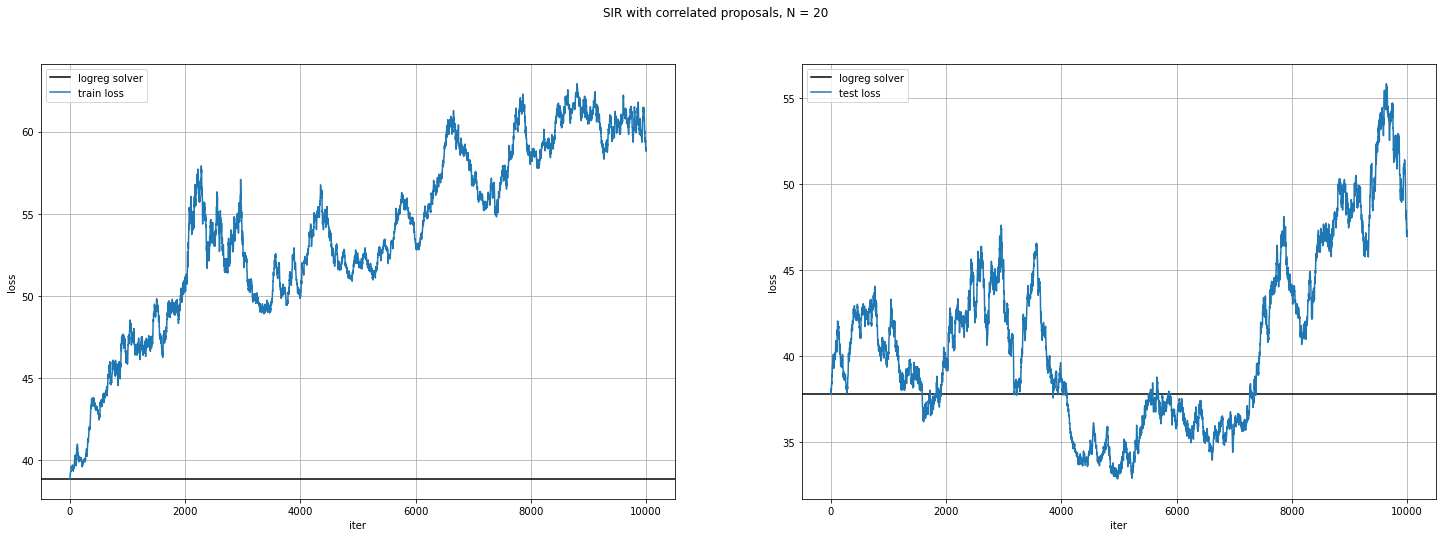

In [75]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25, 8))
name = f'SIR with сorrelated proposals, N = {N}'
fig.suptitle(name)

axs[0].axhline(train_loss_clf, label='logreg solver', color='black')
axs[0].set_xlabel('iter')
axs[0].set_ylabel('loss')
axs[0].plot(np.arange(len(loss_train)), loss_train, label = 'train loss')

axs[1].axhline(test_loss_clf, label='logreg solver', color='black')
axs[1].set_xlabel('iter')
axs[1].set_ylabel('loss')
axs[1].plot(np.arange(len(loss_test)), loss_test, label = 'test loss')


for ax in axs:
    ax.grid()
    ax.legend()

plt.show()

In [76]:
last_w = history[-1].numpy()
clf.coef_ = last_w[:, :-1]
clf.intercept_ = last_w[:, -1]
print(clf.score(X_train_small_scaler, y_train))
print(clf.score(X_test_small_scaler, y_test))

0.8551724137931035
0.7619047619047619


# AIS

In [86]:
from sklearn.linear_model import LogisticRegression
num_iter = np.arange(100) + 1
l2_coef = 0.5
target = BinaryLogisticLoss(l2_coef)
target.log_prob = partial(target.log_prob_args, 
                          X = X_train,
                          y = y_train)
for max_iter in num_iter:
    clf = LogisticRegression(random_state=42,
                             tol=1e-7,
                             max_iter = max_iter,
                             C = 1.).fit(X_train_small, y_train)
    w_clf = torch.FloatTensor(np.concatenate((clf.coef_, clf.intercept_.reshape(1, 1)), axis=1))
    train_loss_clf = target.func(w_clf, X_train, y_train).item()
    test_loss_clf = target.func(w_clf, X_test, y_test).item()
    print(f"max_iter = {max_iter}, train_loss = {train_loss_clf}, test_loss = {test_loss_clf}")

/usr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

max_iter = 1, train_loss = 99.28662872314453, test_loss = 42.49900817871094
max_iter = 2, train_loss = 94.23030090332031, test_loss = 40.01201629638672
max_iter = 3, train_loss = 79.78382873535156, test_loss = 35.72088623046875
max_iter = 4, train_loss = 77.30198669433594, test_loss = 35.9143180847168
max_iter = 5, train_loss = 76.53617858886719, test_loss = 36.64760208129883
max_iter = 6, train_loss = 76.18643951416016, test_loss = 37.23265075683594
max_iter = 7, train_loss = 75.81947326660156, test_loss = 37.725799560546875
max_iter = 8, train_loss = 75.5363998413086, test_loss = 38.059993743896484
max_iter = 9, train_loss = 75.3629379272461, test_loss = 38.14360046386719
max_iter = 10, train_loss = 75.29331970214844, test_loss = 37.927032470703125
max_iter = 11, train_loss = 75.13204193115234, test_loss = 37.54368591308594
max_iter = 12, train_loss = 75.131103515625, test_loss = 37.54471206665039
max_iter = 13, train_loss = 75.11470794677734, test_loss = 37.60944747924805
max_iter =

In [87]:
print(clf.score(X_train_small, y_train))
print(clf.score(X_test_small, y_test))

0.8551724137931035
0.8095238095238095


In [83]:
n_steps = 100
grad_step = 0.01
eps_scale = (2*grad_step)**0.5
N = 20
T = 10
betas = np.linspace(1., 0., T)
#start = w_clf
#start = torch.zeros((1, dim))
scale_proposal = 0.1
random_seed = 42
batch_size = 1
proposal = init_independent_normal(scale_proposal, dim, device)
start = proposal.sample([batch_size])
history = ais_vanilla_dynamics(start, 
                               target.log_prob,
                               proposal, 
                               n_steps, 
                               grad_step, 
                               eps_scale,
                               N, 
                               betas)
loss_train, loss_test = calculate_losses(history, target.func, X_train, X_test, y_train, y_test)

Iter: 0, Training loss: 101.556198, Test loss 43.252117
Iter: 1, Training loss: 94.565834, Test loss 40.489601
Iter: 2, Training loss: 90.195137, Test loss 39.019543
Iter: 3, Training loss: 87.839424, Test loss 38.093048
Iter: 4, Training loss: 85.238602, Test loss 37.032040
Iter: 5, Training loss: 83.878357, Test loss 36.387569
Iter: 6, Training loss: 82.285675, Test loss 35.991493
Iter: 7, Training loss: 81.634354, Test loss 36.026566
Iter: 8, Training loss: 80.706734, Test loss 36.008858
Iter: 9, Training loss: 80.184723, Test loss 35.761532
Iter: 10, Training loss: 79.747604, Test loss 35.783615
Iter: 11, Training loss: 79.108223, Test loss 35.729740
Iter: 12, Training loss: 78.784706, Test loss 35.955288
Iter: 13, Training loss: 79.025543, Test loss 36.079700
Iter: 14, Training loss: 78.321297, Test loss 35.554207
Iter: 15, Training loss: 78.319923, Test loss 35.782677
Iter: 16, Training loss: 77.997314, Test loss 35.849136
Iter: 17, Training loss: 77.895325, Test loss 35.948696
I

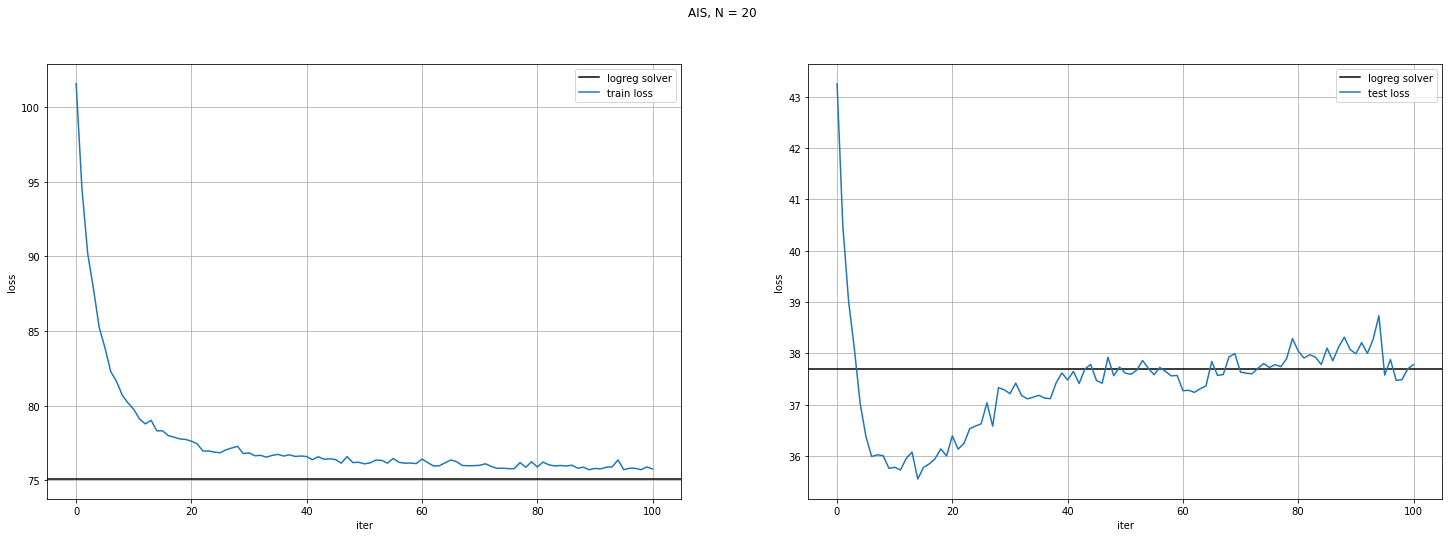

In [84]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25, 8))
name = f'AIS, N = {N}'
fig.suptitle(name)

axs[0].axhline(train_loss_clf, label='logreg solver', color='black')
axs[0].set_xlabel('iter')
axs[0].set_ylabel('loss')
axs[0].plot(np.arange(len(loss_train)), loss_train, label = 'train loss')

axs[1].axhline(test_loss_clf, label='logreg solver', color='black')
axs[1].set_xlabel('iter')
axs[1].set_ylabel('loss')
axs[1].plot(np.arange(len(loss_test)), loss_test, label = 'test loss')


for ax in axs:
    ax.grid()
    ax.legend()

plt.show()

In [85]:
last_w = history[-1].numpy()
clf.coef_ = last_w[:, :-1]
clf.intercept_ = last_w[:, -1]
print(clf.score(X_train_small, y_train))
print(clf.score(X_test_small, y_test))

0.8137931034482758
0.7936507936507936


In [88]:
n_steps = 200
grad_step = 0.01
eps_scale = (2*grad_step)**0.5
N = 20
T = 10
betas = np.linspace(1., 0., T)
rhos = np.linspace(.8, 1., T)[::-1]
#start = w_clf
#start = torch.zeros((1, len(betas), dim))
device = 'cpu'
scale_proposal = 0.1
random_seed = 42
batch_size = 1
proposal = init_independent_normal(scale_proposal, dim, device)
#start = proposal.sample([batch_size, len(betas)])
#start = torch.zeros((1, len(betas), dim))
start = w_clf.unsqueeze(1).repeat(1, len(betas), 1)
start.requires_grad_(True)
history = ais_dynamics(start, target.log_prob, proposal, n_steps, grad_step, eps_scale, N, betas, rhos)

100%|██████████| 200/200 [00:06<00:00, 31.93it/s]


In [89]:
loss_train, loss_test = calculate_losses(history, target.func, X_train, X_test, y_train, y_test)

Iter: 0, Training loss: 75.094955, Test loss 37.700752
Iter: 1, Training loss: 75.094955, Test loss 37.700752
Iter: 2, Training loss: 76.709564, Test loss 35.927048
Iter: 3, Training loss: 80.113335, Test loss 35.892105
Iter: 4, Training loss: 82.751869, Test loss 36.498951
Iter: 5, Training loss: 82.751869, Test loss 36.498951
Iter: 6, Training loss: 82.751869, Test loss 36.498951
Iter: 7, Training loss: 86.330399, Test loss 37.751652
Iter: 8, Training loss: 87.130493, Test loss 38.406845
Iter: 9, Training loss: 90.380386, Test loss 40.044407
Iter: 10, Training loss: 90.674324, Test loss 39.862141
Iter: 11, Training loss: 90.484787, Test loss 39.168079
Iter: 12, Training loss: 90.484787, Test loss 39.168079
Iter: 13, Training loss: 91.688126, Test loss 39.869099
Iter: 14, Training loss: 93.405373, Test loss 41.247074
Iter: 15, Training loss: 91.705353, Test loss 40.203037
Iter: 16, Training loss: 89.865875, Test loss 39.207176
Iter: 17, Training loss: 92.433388, Test loss 39.471130
It

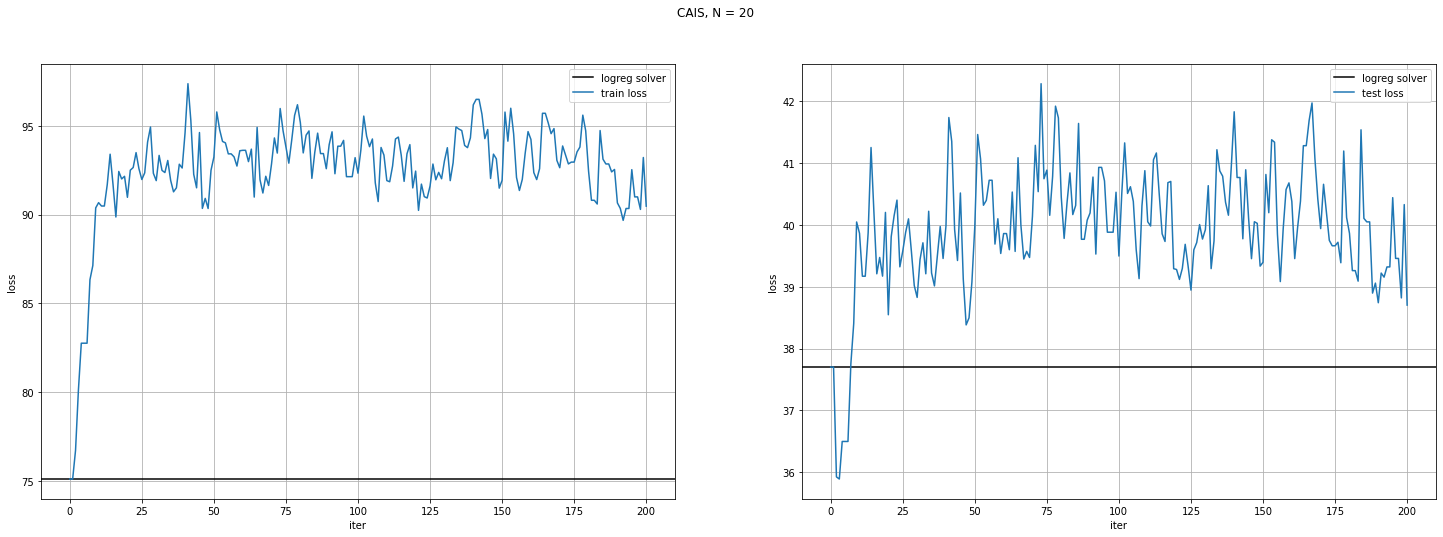

In [90]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25, 8))
name = f'CAIS, N = {N}'
fig.suptitle(name)

axs[0].axhline(train_loss_clf, label='logreg solver', color='black')
axs[0].set_xlabel('iter')
axs[0].set_ylabel('loss')
axs[0].plot(np.arange(len(loss_train)), loss_train, label = 'train loss')

axs[1].axhline(test_loss_clf, label='logreg solver', color='black')
axs[1].set_xlabel('iter')
axs[1].set_ylabel('loss')
axs[1].plot(np.arange(len(loss_test)), loss_test, label = 'test loss')


for ax in axs:
    ax.grid()
    ax.legend()

plt.show()

In [91]:
last_w = history[-1].numpy()
clf.coef_ = last_w[:, :-1]
clf.intercept_ = last_w[:, -1]
print(clf.score(X_train_small, y_train))
print(clf.score(X_test_small, y_test))

0.6758620689655173
0.7619047619047619
